In [27]:
import arfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from sklearn.base import clone
rng = np.random.RandomState(seed=42)

In [28]:
cont_cols = [
    # General
    # 'D_Date',  # Date
    'D_datediff',  # Date
    
    # Random
    'D_AB',
    'D_R',
    'D_H',
    'D_BB',
    'D_PA',
    
    # Batting stats
    'D_SO',    # Strikeouts
    'D_BA',    # Batting Average
    'D_OBP',   # On-Base Percentage
    'D_SLG',   # Slugging Percentage
    'D_OPS',   # On-Base Plus Slugging
    'D_RBI',   # Runs Batted In
    'D_PIT',   # Pitches
    'D_STR',   # Strikes
    'D_WPA',   # Win Probability Added
    'D_aLI',   # Average Leverage Index

    # Pitching stats
    'D_P_H',   # Hits Allowed by Pitcher
    'D_P_R',   # Runs Allowed by Pitcher
    'D_ER',    # Earned Runs by Pitcher
    'D_P_BB',  # Walks by Pitcher
    'D_P_SO',  # Strikeouts by Pitcher
    'D_HR',    # Home Runs Allowed by Pitcher
    'D_ERA',   # Earned Run Average
    'D_CTCT',  # Contact Rate
    'D_STS',   # Swings and Misses (Strikes)
    'D_STL',   # Stolen Bases Against
    'D_GB',    # Ground Balls
    'D_FB',    # Fly Balls
    'D_LD',    # Line Drives
    'D_GSC',   # Game Score
    'D_P_WPA', # Pitcher Win Probability Added
    'D_P_aLI', # Pitcher Average Leverage Index

    # Odds
    'D_Start_Odds',

    # Calculated
    'D_pythagorean',
    
    # Remove later
    # 'D_Final_Score',
    # 'D_Final_Allowed'
]


In [29]:
df = pd.read_csv("./baseballData/SlidingWindow4.csv", index_col=False, low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24766 entries, 0 to 24765
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       24766 non-null  int64  
 1   Date             24766 non-null  object 
 2   H_Won            24766 non-null  float64
 3   D_AB             24766 non-null  float64
 4   D_R              24766 non-null  float64
 5   D_H              24766 non-null  float64
 6   D_BB             24766 non-null  float64
 7   D_PA             24766 non-null  float64
 8   D_SO             24766 non-null  float64
 9   D_BA             24766 non-null  float64
 10  D_OBP            24766 non-null  float64
 11  D_SLG            24766 non-null  float64
 12  D_OPS            24766 non-null  float64
 13  D_RBI            24766 non-null  float64
 14  D_PIT            24766 non-null  float64
 15  D_STR            24766 non-null  float64
 16  D_WPA            24766 non-null  float64
 17  D_aLI       

In [38]:
# Removing the following (judged by previous runs of this file)
drop_cols = [
    'D_ER',
    'D_ERA',
    'D_GSC',
    'D_H',
    'D_OBP',
    'D_PA',
    'D_P_H',
    'D_PIT',
    'D_P_R',
    'D_R',
    'D_RBI',
    'D_STR',
    'D_datediff',
    'D_OPS'   # Removed from correlation matrix
]


y = df['H_Won']
cont_cols_drop = [col for col in cont_cols if col not in drop_cols]
df = df[cont_cols_drop]

KeyError: 'H_Won'

In [31]:
profile = ProfileReport(df, title="Profiling Report")

# Configuration
profile.config.vars.num.skewness_threshold = 1

# Save profile to file

In [37]:
profile.to_widgets()
profile.to_file("MLBEdaReportOne.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/ydata_profiling/profile_report.py:358: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# ARFS and feature selection
[you'll need at least python 3.9 for this](https://github.com/ThomasBury/arfs/issues/29) 

In [33]:
X = df
print(X.shape)
print(y.shape)

(24766, 21)
(24766,)


In [34]:
import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data
from sklearn.pipeline import Pipeline

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/arfs/feature_selection/allrelevant.py:1578: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['D_P_BB' 'D_HR' 'D_FB' 'D_pythagorean']
The agnostic ranking: [1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1 2]
The naive ranking: ['D_pythagorean', 'D_FB', 'D_P_BB', 'D_HR', 'D_STS', 'D_aLI', 'D_P_WPA', 'D_Start_Odds', 'D_STL', 'D_BB', 'D_LD', 'D_BA', 'D_GB', 'D_OPS', 'D_WPA', 'D_AB', 'D_P_SO', 'D_P_aLI', 'D_SLG', 'D_CTCT', 'D_SO']


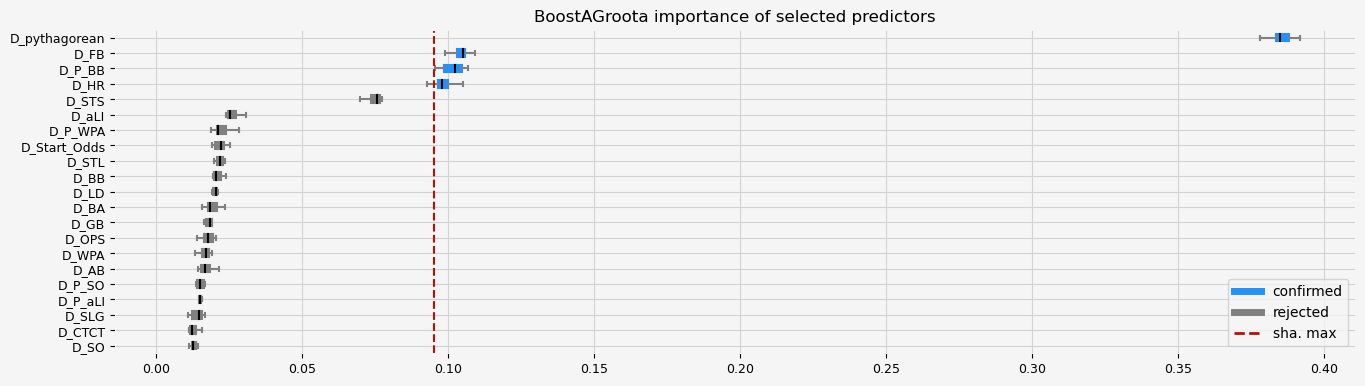

In [35]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# Leshy

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	2
Tentative: 	1
Rejected: 	18
All relevant predictors selected in 00:00:01.19
The selected features: ['D_P_BB' 'D_pythagorean']
The agnostic ranking: [ 7  9 15 20 16 18  6 11  1  5 19 14  2 16 13  4 12  7  9  3  1]
The naive ranking: ['D_pythagorean', 'D_P_BB', 'D_STS', 'D_Start_Odds', 'D_FB', 'D_P_SO', 'D_P_aLI', 'D_AB', 'D_P_WPA', 'D_WPA', 'D_BB', 'D_aLI', 'D_GB', 'D_LD', 'D_CTCT', 'D_SLG', 'D_SO', 'D_STL', 'D_BA', 'D_HR', 'D_OPS']


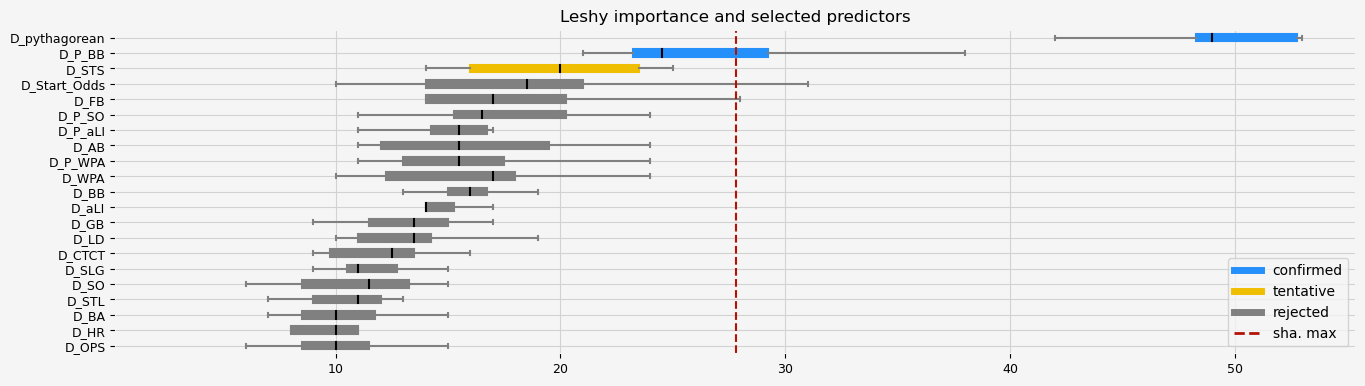

In [36]:
model = LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# Removing the following
drop_cols = [
    'D_ER',
    'D_ERA',
    'D_GSC',
    'D_H',
    'D_OBP',
    'D_PA',
    'D_P_H',
    'D_PIT',
    'D_P_R',
    'D_R',
    'D_RBI',
    'D_STR',
    'D_datediff'
]